In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import pickle
from shapely.geometry import Polygon

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


# dask

In [26]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setupcloseur PBSCluster (Casper)
ncores=1
nmem='16GB'
cluster = PBSCluster(
    n_workers=16,
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='UMSU0012', # Input your project ID here
    walltime='00:10:00', # Amount of wall time
    interface='mgt', # Interface to use
)
# Setup your client
client = Client(cluster)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42375 instead
  f"Port {expected} is already in use.\n"


In [27]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/42375/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/42375/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.206.19:40761,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/42375/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
def read_storge(rofdir, start_date, end_date, nlat, nlon, lats, lons):
    y1 = int(start_date[:4])
    y2 = int(end_date[:4])
    time = pd.date_range(
        str(y1) + "-01-01",
        str(y2) + "-12-31",
        freq="D",
    )
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_store = []
    for year in range(y1, y2 + 1):
        # print('processing', year)
        qfile = rofdir + "storge%i.bin" % year
        if not os.path.isfile(qfile):
            print("doesn't exist", qfile)
            continue
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_store.append(outflw)
    store = xr.DataArray(
        np.vstack(list_store),
        dims=("time", "lat", "lon"),
        coords={"time": time, "lat": lats, "lon": lons},
    )
    return store

def read_outflw(rofdir, start_date, end_date, nlat, nlon, lats, lons):
    y1 = int(start_date[:4])
    y2 = int(end_date[:4])
    time = pd.date_range(
        str(y1) + "-01-01",
        str(y2) + "-12-31",
        freq="D",
    )
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_outflw = []
    for year in range(y1, y2 + 1):
        # print('processing', year)
        qfile = rofdir + "outflw%i.bin" % year
        if not os.path.isfile(qfile):
            print("doesn't exist", qfile)
            continue
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_outflw.append(outflw)
    outflw = xr.DataArray(
        np.vstack(list_outflw),
        dims=("time", "lat", "lon"),
        coords={"time": time, "lat": lats, "lon": lons},
    )
    return outflw

def get_gridcell_stations(sel_daminfo, qsim_grid):
    tmp = {}
    for idx, row in sel_daminfo.iterrows():
        xi0, yj0 = row.drt_pxi0, row.drt_pyj0
        qsim_sti = qsim_grid.isel(lat=yj0, lon=xi0)
        qsim_sti = qsim_sti.reset_coords(("lat", "lon"), drop=True)
        tmp[str(idx)] = qsim_sti
    mdl = xr.Dataset(tmp)
    return mdl

def get_gridcell_reservoir(sel_daminfo, sim, res_extent):
    tmp = {}
    res_extent_grd = res_extent.stack(ngrd=("lat", "lon"))
    sim_grd = sim.stack(ngrd=("lat", "lon"))
    for idx, row in sel_daminfo.iterrows():
        ma = np.where(res_extent_grd == idx)[0]
        sim_res = sim_grd.isel(ngrd=ma).sum("ngrd")  # /1.223e3 # m3 to acre-ft
        tmp[str(idx)] = sim_res
    sim_store = xr.Dataset(tmp)
    return sim_store

def grid_polygon_intersect(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res),
                      (x-res, y+res),
                      (x+res, y+res),
                      (x+res,y-res),
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    ln1,lt1,ln2,lt2 = geom.bounds
    ma = (lons>ln1)&(lons<ln2)&(lats>lt1)&(lats<lt2)
    idx = np.where(ma)[0]
    print('searching for grid intersections ...')
    for ii in idx:
        mask[ii] = geom.intersects(gridcells[ii])
    print('intersecting grid total:', mask.sum(), 'out of', ngrd)
    return mask

# def get_res_inflows(sim, sel_daminfo, dam_grids, dam_location, nextx, nexty):
#     dict_inflows = {}
#     sim_grd = sim.stack(ngrd=("lat", "lon"))
#     for idx, row in sel_daminfo.iterrows():
#         list_gi = []
#         for gi,i,j in zip(np.arange(dam_grids.size), nextx.ravel(), nexty.ravel()):
#             if (i>=0 and j>=0):
#                 if (dam_location[j-1,i-1] == idx):
#                     list_gi.append(gi)
#         dam_inflow = sim_grd.isel(ngrd=list_gi).sum('ngrd')
#         dict_inflows[str(idx)] = dam_inflow
#     sim_inflows = xr.Dataset(dict_inflows)
#     return sim_inflows

def get_res_inflows(sim, sel_daminfo, res_data, nextx, nexty, dict_inflow_grids={}):
    dict_inflows = {}
    res_datar = res_data.ravel()
    sim_grd = sim.stack(ngrd=("lat", "lon"))
    for idx, row in sel_daminfo.iterrows():
        list_gi = []
        for gi,i,j in zip(np.arange(res_datar.size), nextx.ravel(), nexty.ravel()):
            if (i>=0 and j>=0):
                if (res_data[j-1,i-1] == idx) and (res_datar[gi] == 0):
                    list_gi.append(gi)
        # dict_inflow_grids[str(idx)] = list_gi
        if len(list_gi)>0:
            dam_inflow = sim_grd.isel(ngrd=list_gi)
            # dict_inflows[str(idx)] = dam_inflow.sum('ngrd')
            gi = int(dam_inflow.mean('time').argmax('ngrd'))
            dict_inflows[str(idx)]  = dam_inflow.isel(ngrd=gi).reset_coords('ngrd', drop=True)
    sim_inflows = xr.Dataset(dict_inflows)
    return sim_inflows

# analysis

In [3]:
damids = ['610','597','601','451','132','148','198','210']
start_date = "1980-10-01"
end_date = "2020-09-30"
tdelta = slice(start_date, end_date)

In [4]:
res_nat_gauge = {'132':'SIS', # SBB
                 '148':'FTO',
                 '198':'SNS',
                 '210':'TLG',
                 '601':'09355500',
                 '451':'09234500',
                 '597':'09380000',
                 '610':'09380000',
                 }

In [5]:
# reservoirs drainage area
gdf_ca_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU8.shp')
gdf_ucr_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU8.shp')
gdf_ucr_huc4 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU4.shp')
gdf_lcr_huc4 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU4.shp')
#
res_gdf_basin = {}
res_gdf_basin['132'] = gdf_ca_huc8[gdf_ca_huc8['huc8'].str.startswith('180200')]
res_gdf_basin['148'] = gdf_ca_huc8[gdf_ca_huc8['huc8']=='18020123']
res_gdf_basin['198'] = gdf_ca_huc8[gdf_ca_huc8['huc8']=='18040010']
res_gdf_basin['210'] = gdf_ca_huc8[gdf_ca_huc8['huc8']=='18040009']
#
res_gdf_basin['610'] = pd.concat([gdf_ucr_huc4, gdf_lcr_huc4[gdf_lcr_huc4['huc4'].isin(['1501','1502'])]])
res_gdf_basin['597'] = gdf_ucr_huc4
res_gdf_basin['451'] = gdf_ucr_huc4[gdf_ucr_huc4['huc4']=='1404']
res_gdf_basin['601'] = gdf_ucr_huc8[gdf_ucr_huc8['huc8'].isin(['14080102', '14080101'])]

In [6]:
# Observations

In [7]:
# releases and inflows
obsdir = '/glade/work/elkoukah/inputs/obs/ResOpsUS/ResOpsUS/time_series_all/'
obs_release = xr.Dataset()
obs_storage = xr.Dataset()
obs_inflows = xr.Dataset()
for damid in damids:
    # print(damid)
    data = pd.read_csv(obsdir+f'ResOpsUS_{damid}.csv')
    time = data["date"].values.astype("datetime64[D]")
    da_s = xr.DataArray(data['storage'].values.astype(float), dims=("time"), coords={"time": time})
    da_r = xr.DataArray(data['outflow'].values.astype(float), dims=("time"), coords={"time": time})
    da_i = xr.DataArray(data['inflow'].values.astype(float), dims=("time"), coords={"time": time})
    obs_release[damid] = da_r.sel(time=tdelta)
    obs_storage[damid] = da_s.sel(time=tdelta)
    obs_inflows[damid] = da_i.sel(time=tdelta)

# natural flows
qobs_swna = xr.open_dataset('out/natural_flow_swna.nc')
qnat_obs = xr.Dataset({k:qobs_swna[v] for k,v in res_nat_gauge.items()}).sel(time=tdelta)

In [8]:
obs_inflows_mon = obs_inflows.resample(time='1M').mean()
obs_inflows_mon['610'] = obs_release['597'].resample(time='1M').mean()
obs_inflows_mon['148'] = qnat_obs['148']

In [9]:
# Simulations

In [10]:
# Release

In [11]:
camadir = "/glade/work/elkoukah/empirical/reservoirs/cama400/"

exp = 'fullDams'

daminfo_file = camadir + f"my_dams_setup/pxpy_qmax_my_dam_list_sw_{exp[:-4]}.xlsx"
daminfo = pd.read_excel(daminfo_file, index_col="ID")

daminfo_file = camadir + f"my_dams_setup/pxpy_qmax_my_dam_list_sw_major.xlsx"
daminfo_major = pd.read_excel(daminfo_file, index_col="ID")

df_resopus = pd.read_csv('/glade/work/elkoukah/inputs/obs/ResOpsUS/ResOpsUS/attributes/reservoir_attributes.csv')
damspecs = pd.read_csv(f'/glade/derecho/scratch/elkoukah/inputs/CFD/SW4km-opt_{exp}_1980-2020_399x299/spec/dam_info_istarf_final_irr_usgs.csv', 
                       index_col="ID")

ma = daminfo.reset_index()['ID'].isin(df_resopus['DAM_ID'])
daminfo_obs = daminfo[ma.values]

res = 0.05
x0 = -124.950
x1 = -105.000
y0 = 30.000
y1 = 44.950
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size

res_extent_file = f"/glade/derecho/scratch/elkoukah/inputs/CFD/SW4km-opt_{exp}_1980-2020_399x299/bin/dam_reservoir_map/reservoir_extent_399x299.int"
res_extent = np.fromfile(res_extent_file, "i4")
res_extent = xr.DataArray(res_extent.reshape(nlat, nlon),dims=("lat", "lon"),coords={"lat": lats, "lon": lons},)
archivedir = "/glade/derecho/scratch/elkoukah/archive/"

damloc_file = f"/glade/derecho/scratch/elkoukah/inputs/CFD/SW4km-opt_{exp}_1980-2020_399x299/bin/dam_reservoir_map/dam_location_399x299.int" 
dam_location = np.fromfile(damloc_file, '<i').reshape(-1,nlat,nlon)[0]
dam_grids = dam_location.ravel()

mapdir = "/glade/work/elkoukah/empirical/reservoirs/cama400/map/SW_3min/"
nextxy = np.fromfile(mapdir+'nextxy.bin', '<i').reshape(-1,nlat,nlon)
nextx, nexty = nextxy

In [12]:
# Eval period
start_date = "1980-01-01"
end_date = "2020-12-31"

# opt, empirical, cu
caseid_dam = "prod_swna_4km_new_surfdata_conus404.opt_001"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_irrUSGS_{exp}_Isim/"
flw_opt_empirical_cu_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
store_opt_empirical_cu_grid = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
flw_opt_empirical_cu = get_gridcell_stations(daminfo_obs, flw_opt_empirical_cu_grid)
store_opt_empirical_cu = get_gridcell_reservoir(daminfo_obs, store_opt_empirical_cu_grid, res_extent)
mdl_release = flw_opt_empirical_cu[damids].sel(time=tdelta)

In [13]:
# res inflows
sim_inflows = get_res_inflows(flw_opt_empirical_cu_grid, daminfo_obs, res_extent.data, nextx, nexty)

In [14]:
# Streamflow
qmdl = xr.open_dataset('out/qmdl_opt_swna.nc')
qnat_clmopt = xr.Dataset({k:qmdl[v] for k,v in res_nat_gauge.items()}).sel(time=tdelta)

In [15]:
rofdir_dam = archivedir + caseid_dam + f"/rof/NAT_3min_1980-2020_fixlat/"
flw_opt_nat_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
sim_inflows_nat = get_gridcell_stations(daminfo_obs, flw_opt_nat_grid)
sim_inflows_nat['610'] = flw_opt_empirical_cu['597'] #modify for hoover

In [16]:
# modify inflow to hoover
# qnat_obs['610'] = obs_release['597'].resample(time='1M').mean()
# qnat_clmopt['610'] = mdl_release['597']

qnat_obs['610'] = qnat_obs['597']
qnat_clmopt['610'] = qnat_clmopt['597']

# qnat_obs['610'] = obs_inflows['597'].resample(time='1M').mean()
# qnat_clmopt['610'] = sim_inflows['597']

In [17]:
metrics = ['delI', 'delR', 'del(I-R)', '(I-R)', '(dR/dI)']
cols = pd.MultiIndex.from_product([['obs','mdl'], metrics])
df_del_res_ir = pd.DataFrame(np.full((len(damids), len(cols)),np.nan), columns=cols, index=damids)

tdelta0 = slice('1980-10', '1999-09')
tdelta1 = slice('1999-10', '2020-09')
for damid in damids:
    rmean_obs = obs_release[damid].resample(time='1M').mean().dropna('time')
    imean_obs = qnat_obs[damid].sel(time=rmean_obs.time)
    rmean_mdl = mdl_release[damid].resample(time='1M').mean().sel(time=rmean_obs.time)
    imean_mdl = qnat_clmopt[damid].resample(time='1M').mean().sel(time=rmean_obs.time)
    maxcap = int(obs_storage[damid].max()*10**6) #from obs (better)
    cf = 365*24*60**2/maxcap

    imean = imean_obs.sel(time=tdelta).mean('time')
    rmean = rmean_obs.sel(time=tdelta).mean('time')
    dimean_obs = (imean_obs.sel(time=tdelta1).mean('time')-imean_obs.sel(time=tdelta0).mean('time'))
    drmean_obs = (rmean_obs.sel(time=tdelta1).mean('time')-rmean_obs.sel(time=tdelta0).mean('time'))
    df_del_res_ir.loc[damid, ('obs', 'delI')] = float(dimean_obs/imean)*100
    df_del_res_ir.loc[damid, ('obs', 'delR')] = float(drmean_obs/rmean)*100
    df_del_res_ir.loc[damid, ('obs', '(dR/dI)')] = float(drmean_obs/dimean_obs)*100

    imean = imean_mdl.sel(time=tdelta).mean('time')
    rmean = rmean_mdl.sel(time=tdelta).mean('time')
    dimean_mdl = (imean_mdl.sel(time=tdelta1).mean('time')-imean_mdl.sel(time=tdelta0).mean('time'))
    drmean_mdl = (rmean_mdl.sel(time=tdelta1).mean('time')-rmean_mdl.sel(time=tdelta0).mean('time'))
    df_del_res_ir.loc[damid, ('mdl', 'delI')] = float(dimean_mdl/imean)*100
    df_del_res_ir.loc[damid, ('mdl', 'delR')] = float(drmean_mdl/rmean)*100
    df_del_res_ir.loc[damid, ('mdl', '(dR/dI)')] = float(drmean_mdl/dimean_mdl)*100

    d0_obs = (imean_obs.sel(time=tdelta0).mean('time')-rmean_obs.sel(time=tdelta0).mean('time'))
    d1_obs = (imean_obs.sel(time=tdelta1).mean('time')-rmean_obs.sel(time=tdelta1).mean('time'))
    dimbalance_obs = (d1_obs-d0_obs)#/rmean_obs.sel(time=tdelta1).mean('time')
    df_del_res_ir.loc[damid, ('obs', 'del(I-R)')] = float(dimbalance_obs*cf)*100
    df_del_res_ir.loc[damid, ('obs', '(I-R)')] = float(d1_obs*cf)*100

    d0_mdl = (imean_mdl.sel(time=tdelta0).mean('time')-rmean_mdl.sel(time=tdelta0).mean('time'))
    d1_mdl = (imean_mdl.sel(time=tdelta1).mean('time')-rmean_mdl.sel(time=tdelta1).mean('time'))
    dimbalance_mdl = (d1_mdl-d0_mdl)#/rmean_mdl.sel(time=tdelta1).mean('time')
    df_del_res_ir.loc[damid, ('mdl', 'del(I-R)')] = float(dimbalance_mdl*cf)*100
    df_del_res_ir.loc[damid, ('mdl', '(I-R)')] = float(d1_mdl*cf)*100
    # df_del_res_ir.loc[damid, ('obs', 'del(I-R)_t0')] = float(d0_obs/rmean_obs.sel(time=tdelta0).mean('time'))*100
    # df_del_res_ir.loc[damid, ('obs', 'del(I-R)_t1')] = float(d1_obs/rmean_obs.sel(time=tdelta1).mean('time'))*100
    # df_del_res_ir.loc[damid, ('mdl', 'del(I-R)_t0')] = float(d0_mdl/rmean_mdl.sel(time=tdelta0).mean('time'))*100
    # df_del_res_ir.loc[damid, ('mdl', 'del(I-R)_t1')] = float(d1_mdl/rmean_mdl.sel(time=tdelta1).mean('time'))*100

In [18]:
# for all reservoirs
df_alldams = daminfo_obs[['Project name','Lat','Lon']].copy()
imean = sim_inflows_nat.sel(time=tdelta)
rmean = flw_opt_empirical_cu.sel(time=tdelta)
tdelta0 = slice('1980-10', '1999-09')
tdelta1 = slice('1999-10', '2020-09')
for damid in imean.data_vars:
    dimean_mdl = (imean[str(damid)].sel(time=tdelta1).mean('time')-imean[str(damid)].sel(time=tdelta0).mean('time'))
    drmean_mdl = (rmean[str(damid)].sel(time=tdelta1).mean('time')-rmean[str(damid)].sel(time=tdelta0).mean('time'))
    df_alldams.loc[int(damid), 'dI'] = float(dimean_mdl/imean[str(damid)].mean('time'))*100
    df_alldams.loc[int(damid), 'dR'] = float(drmean_mdl/rmean[str(damid)].mean('time'))*100
    df_alldams.loc[int(damid), '(dR/dI)'] = float(drmean_mdl/dimean_mdl)*100
df_alldams = df_alldams.replace([np.inf, -np.inf], np.nan)

In [20]:
# reservoir basins aggregated simulation

In [ ]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'prod_swna_4km_new_surfdata_conus404.opt_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))

data_vars = ['RAIN', 'SNOW', 'TWS', 'QRUNOFF', 'QDRAI', 'QOVER', 'H2OSNO', 'QSNOMELT', 'FSNO',
             'QSOIL', 'QVEGT', 'QVEGE', 'TOTSOILLIQ',
             'TOTSOILICE', 'SOILWATER_10CM', 'FSDS', 'FSR', 'FSA', 'FIRA', 'FLDS', 'FIRE']
def preprocess(ds):
    return ds[data_vars]
h0 = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

tdelta = slice('1980-10', '2020-09')
h0 = h0.sel(time=tdelta).compute()
h0['lon'] = h0['lon']-360

rnet = h0['FSA']-h0['FIRA']
# rnet = h0['FSDS']-h0['FSR']+h0['FLDS']-h0['FIRE']
h0['Rnet'] = rnet

asa = h0['FSR']/h0['FSDS']
h0['ASA'] = asa

prec = h0['RAIN']+h0['SNOW']
h0['PREC'] = prec

et = h0['QSOIL']+h0['QVEGT']+h0['QVEGE']
h0['ET'] = et

soilwater = h0['TOTSOILICE']+h0['TOTSOILLIQ']
h0['SM'] = soilwater

h0_wy = h0.resample(time='A-SEP').mean()
# h0_wy.to_netcdf('out/h0_wy.nc')

In [19]:
h0_wy = xr.open_dataset('out/h0_wy.nc')

In [20]:
dict_res_basin_mask = pickle.load(open('out/dict_res_basin_mask.pkl', 'rb'))
# dict_res_basin_mask = {}
lons, lats = np.meshgrid(h0_wy['lon'], h0_wy['lat'])
for damid in damids:
    print(damid)
    if damid in dict_res_basin_mask.keys():
        continue
    gdfi = res_gdf_basin[damid]
    geom = gdfi['geometry'].iloc[0]
    if len(gdfi)>1:
        geom = gdfi.unary_union
    mask = grid_polygon_intersect(lats.ravel(), lons.ravel(), 0.02, geom)
    dict_res_basin_mask[damid] = mask
# pickle.dump(dict_res_basin_mask, open('out/dict_res_basin_mask.pkl', 'wb'))
# da_tmp = (~h0['RAIN'][0].isnull())*1
# weightmap = xa.pixel_overlaps(da_tmp, gdfi)
# gdfi = gpd.GeoDataFrame({'objectid':[1], 'geometry':Polygon(geom.exterior)}, crs='EPSG:4326')

610
597
601
451
132
148
198
210


In [21]:
tdelta0 = slice('1980-10', '1999-09')
tdelta1 = slice('1999-10', '2020-09')
cols = list(h0_wy.data_vars)
df_del_res = pd.DataFrame(np.full((len(damids), len(cols)),np.nan), columns=cols, index=damids)
cf = 365*24*60**2

for damid in damids:
    print(damid, '...')
    mask = dict_res_basin_mask[damid]
    h0_wy_res = h0_wy.stack(ngrd=('lat','lon')).sel(ngrd=(mask>0)).mean('ngrd')
    h0_wy_res0 = h0_wy_res.sel(time=tdelta0).mean('time')
    h0_wy_res1 = h0_wy_res.sel(time=tdelta1).mean('time')

    for var in cols:
        if var in ['RAIN', 'SNOW', 'QRUNOFF', 'QDRAI', 'QOVER', 'QSNOMELT', 'QSOIL', 'QVEGT', 'PREC', 'ET']:
            dt = (h0_wy_res1[var]-h0_wy_res0[var])*cf
        elif var in ['Rnet']:
            dt = (h0_wy_res1[var]-h0_wy_res0[var])*cf/(2.26*10**6)
        elif var in ['TWS', 'TOTSOILLIQ', 'TOTSOILICE', 'SOILWATER_10CM', 'SM']:
            dt = (h0_wy_res1[var]-h0_wy_res0[var])/h0_wy_res0[var] * 100
        else:
            dt = h0_wy_res1[var]-h0_wy_res0[var]
        df_del_res.loc[damid, var] = float(dt)

610 ...
597 ...
601 ...
451 ...
132 ...
148 ...
198 ...
210 ...


In [22]:
import matplotlib.gridspec as gridspec

In [23]:
    # ax.axhspan(-0.5, 2.5, facecolor='tab:blue', alpha=0.5)
    # ax.axhspan(2.5, 3.5, facecolor='tab:cyan', alpha=0.5)
    # ax.axhspan(3.5, 6.5, facecolor='tab:green', alpha=0.5)
    # ax.axhspan(6.5, 9.5, facecolor='tab:purple', alpha=0.5)

ylabels = ['Precipitation', 'Rainfall', 'Snowfall',
           'Soil Evaporation', 'Transpiration', 'Evapotranspiration',
           'Snowmelt', 'Subsurface Runoff', 'Surface Runoff', 'Total Runoff']
ylabels2  = ['Inflow', 'Release', '(Inflow - Release)']
colors = ['tab:blue','tab:blue','tab:blue',
          'tab:cyan',
          'tab:green','tab:green','tab:green',
          'tab:purple','tab:purple','tab:purple']
colors2 = ['tab:orange','tab:green','tab:blue']


In [24]:
palette = sns.color_palette("husl", 8)

c_prec = palette[-3]
c_melt = palette[-1]
c_et = palette[4]
c_q = palette[-2]
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

In [25]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

gdf_sw_plot = pd.concat([gdf_ucrb, gdf_lcrb, gdf_ca, gdf_sw])
gdf_sw_plot = gdf_sw_plot.to_crs(ccrs.PlateCarree())

In [26]:
from matplotlib.legend_handler import HandlerTuple

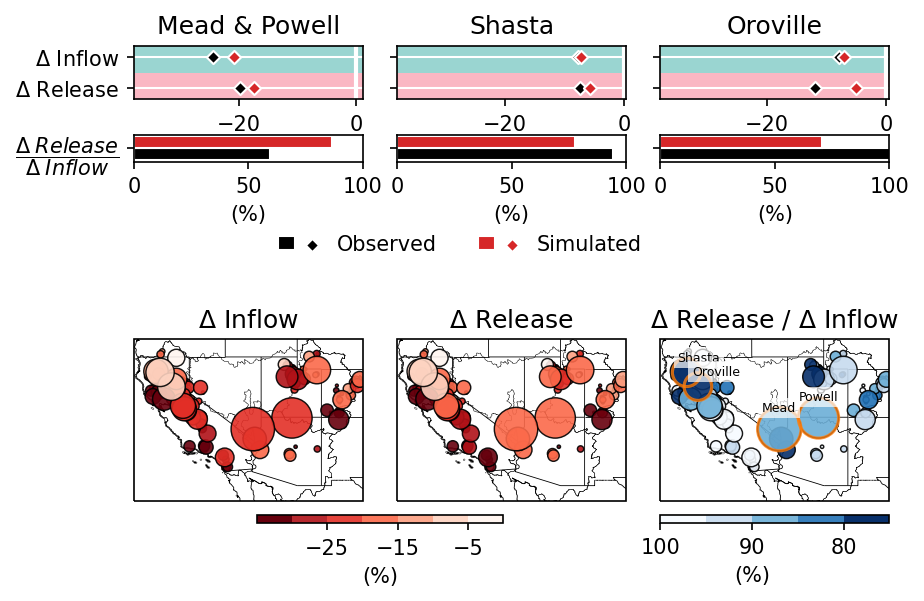

In [231]:
yvars = ['PREC', 'RAIN', 'SNOW',  'QSNOMELT', 'QSOIL', 'QVEGT', 'ET', 'QDRAI', 'QOVER', 'QRUNOFF']
ylabels = [r'$\Delta$ Precipitation', r'$\Delta$ Rainfall', r'$\Delta$ Snowfall', r'$\Delta$ Snowmelt',
           r'$\Delta$ Soil Evaporation', r'$\Delta$ Transpiration', r'$\Delta$ Evapotranspiration',
           r'$\Delta$ Subsurface Runoff', r'$\Delta$ Surface Runoff', r'$\Delta$ Total Runoff']
colors = [c_q,c_q,c_q,
          c_et,c_et,c_et,
          c_melt,
          c_prec,c_prec,c_prec]

yvars2 = ['delI', 'delR']
ylabels2  = [r'$\Delta$ Inflow', r'$\Delta$ Release']
colors2 = [palette[0],c_et,c_q]
xlims = [(-38,None),(-38,None),(-38,None),(-31,None),
 (-10.5,None),(-15,5),(-10.5,None),(None,None)
]

fig = plt.figure(figsize=(6.5,4.5), dpi=150)
gspec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig, height_ratios=[.2,.1, 0.2, 1],
                         hspace=.35, wspace=.35)

titles = ['Mead & Powell', 'Shasta', 'Oroville']
damids_plot = ['610', '132', '148']
k = 0
for i in range(len(damids_plot)):
    damid = damids_plot[i]
    ax = plt.subplot(gspec[0,k:k+2])
    for j,c in zip(range(0,len(ylabels2)), colors2):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data_obs = df_del_res_ir.loc[damid, 'obs'].loc[yvars2].reset_index()[::-1]
    data_mdl = df_del_res_ir.loc[damid, 'mdl'].loc[yvars2].reset_index()[::-1]
    data_obs.plot.scatter(y='index', x=damid, marker='D', c='k', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9, label='Observed')
    data_mdl.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9, label='Simulated')
    ax.set_xlabel('')
    ax.set_title(titles[i])
    ax.set_yticks(range(len(ylabels2))[::-1], ['']*len(ylabels2))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels2))[::-1], ylabels2)
    ax.set_ylabel('')
    ax.set_ylim(-0.35,1.35)
    if xlims[i][0] is not None:
        ax.set_xlim(*xlims[i])
    # ax.margins(0.1)
    ax.get_legend().remove()
    p1 , p2 =  ax.get_legend_handles_labels()[0]

    ax = plt.subplot(gspec[1,k:k+2])
    k += 2
    val_obs = df_del_res_ir.loc[damid, 'obs'].loc['(dR/dI)']
    val_mdl = df_del_res_ir.loc[damid, 'mdl'].loc['(dR/dI)']
    ax.barh(0, val_obs, height=1, color='k', edgecolor='w', label='Observed')
    # ax.barh(0, 100-val_obs, left=val_obs, height=1, color='k', edgecolor='w', hatch=['xxxxx'])
    ax.barh(1, val_mdl, height=1, color='tab:red', edgecolor='w', label='Simulated')
    # ax.barh(1, 100-val_mdl, left=val_mdl, height=1, color='tab:red', edgecolor='w', hatch=['xxxxx'])
    ax.set_yticks([0.5], [''])
    if i==0 or i==4:
        ax.set_yticks([0.5], [r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$'])
    ax.set_xlim(0,100)
    ax.set_xlabel('(%)')
    p3 , p4 =  ax.get_legend_handles_labels()[0]
    # if i==3: break


ax.legend([(p3, p1), (p4,p2)], ['Observed', 'Simulated'], ncol=2,
               handler_map={tuple: HandlerTuple(ndivide=None)},
         bbox_to_anchor=(0,-2), frameon=False)

df = df_alldams.copy()
df.loc[610, ['dI','dR','(dR/dI)']] = df_del_res_ir.loc['610', ('mdl', ['delI','delR','(dR/dI)'])].values
df.loc[597, ['dI','dR','(dR/dI)']] = df_del_res_ir.loc['610', ('mdl', ['delI','delR','(dR/dI)'])].values
df.loc[132, ['dI','dR','(dR/dI)']] = df_del_res_ir.loc['132', ('mdl', ['delI','delR','(dR/dI)'])].values
df.loc[148, ['dI','dR','(dR/dI)']] = df_del_res_ir.loc['148', ('mdl', ['delI','delR','(dR/dI)'])].values
df['size'] = np.maximum(np.log10(daminfo_obs['Total storage (FSL, Mm3)']),0)**4
df = df.sort_values('size')
#
ax0 = plt.subplot(gspec[3,:2], projection=ccrs.PlateCarree())
ax1 = plt.subplot(gspec[3,2:4], projection=ccrs.PlateCarree())
axes = [ax0, ax1]
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
extent = (-124.6, -105.6, 30.02, 43.46)
metrics = ('dI', 'dR')
cmap = 'Reds_r'
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(-30,0,5), ncolors=256, extend='both')
titles = [r'$\Delta$ Inflow', r'$\Delta$ Release']
for ax,metric,title in zip(axes, metrics, titles):
    ax.set_title(title)
    gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
    ax.add_feature(cfeature.BORDERS, lw=.4)
    ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
    ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
    fc = ax.scatter(df['Lon'], df['Lat'], c=df[metric], s=df['size'], alpha=.9, 
                    cmap=cmap, norm=norm, edgecolor='k', lw=.7, zorder=2)
    ax.set_extent(extent)
cb = plt.colorbar(fc,ax=axes,label='(%)', location='bottom',aspect=30, shrink=.5,
                  extendfrac='auto', ticks=[-25,-15,-5], extendrect=True, pad=0.05)
#
cmap = 'Blues'
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,21,5), ncolors=256, extend='max')
ax = plt.subplot(gspec[3,4:], projection=ccrs.PlateCarree())
# ax.set_title(r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$')
ax.set_title(r'$\Delta$ Release $/$ $\Delta$ Inflow')
gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
ax.add_feature(cfeature.BORDERS, lw=.4)
ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
fc = ax.scatter(df['Lon'], df['Lat'], c=(100-df['(dR/dI)']), s=df['size'], alpha=.9, 
                cmap=cmap, norm=norm, edgecolor='k', lw=.7, zorder=2)
ax.set_extent(extent)
cb = plt.colorbar(fc,ax=ax, label='(%)', location='bottom',aspect=30,
                  extendfrac='auto', extendrect=True, pad=0.05)
# cb.ax.set_xticks([0,10,20,30,40], [100,90,80,70,60]);
cb.ax.set_xticks([0,10,20], [100,90,80]);

sel_damids = [610,597,132,148]
offsets = [1.8,1.8,.75,.75]
ax.scatter(df.loc[sel_damids]['Lon'], df.loc[sel_damids]['Lat'], 
           c='None', s=df.loc[sel_damids]['size'], alpha=.8, edgecolor='tab:orange', ls='-', lw=1.5, zorder=4)

names = ['Mead', 'Powell', 'Shasta', 'Oroville']
offset = [(0,1.75),(0,1.75), (1,1.25), (1.5,1.25)]
for i, damid in enumerate(sel_damids[:4]):
    xf,yf = offset[i]
    # df.loc[damid, 'Project name']
    ax.annotate(names[i], color='k', fontsize=6,
            xy=(df.loc[damid, 'Lon']+xf, df.loc[damid, 'Lat']+yf), xycoords='data',
            # xytext=(df.loc[damid, 'Lon'], df.loc[damid, 'Lat']), textcoords='data',
            ha="center", va="center",
            bbox=dict(boxstyle="square", fc="w", edgecolor="None", alpha=.7), zorder=9)

In [233]:
fig.savefig('./figs/re_res_changes_2.png', dpi=600, bbox_inches='tight')

In [234]:
df_del_res_ir.loc['610']

obs  delI       -24.443481
     delR       -19.831296
     del(I-R)    -5.241263
     (I-R)       11.669583
     (dR/dI)     59.357393
mdl  delI       -20.788571
     delR       -17.414635
     del(I-R)    -1.505966
     (I-R)       -2.307059
     (dR/dI)     86.293161
Name: 610, dtype: float64

In [104]:
df_del_res_ir.loc['610']

obs  delI        -35.570451
     delR        -19.831296
     del(I-R)     -5.945059
     (I-R)        -3.189728
     (dR/dI)      56.285612
mdl  delI        -22.904027
     delR        -17.414635
     del(I-R)      1.201363
     (I-R)       -17.722812
     (dR/dI)     114.509845
Name: 610, dtype: float64

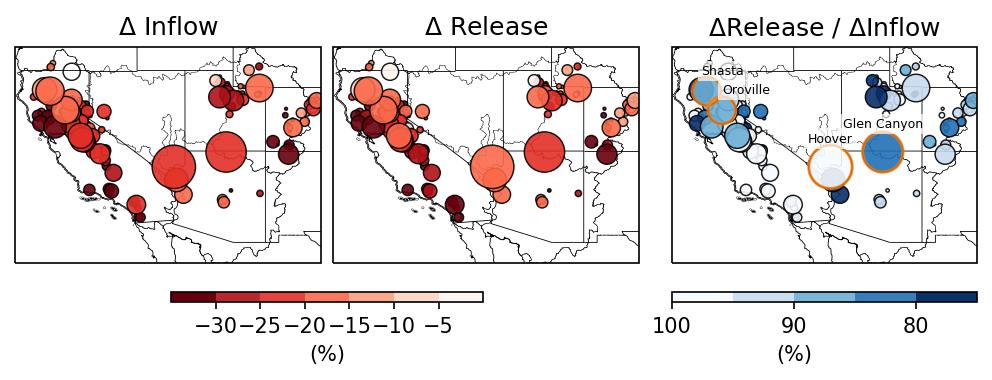

In [206]:
df = df_alldams.copy()
df['size'] = np.maximum(np.log10(daminfo_obs['Total storage (FSL, Mm3)']),0)**4
df = df.sort_values('size')

fig, axes = plt.subplots(1,3, figsize=(6.5,4), dpi=150, constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
extent = (-124.6, -105.6, 30.02, 43.46)
metrics = ('dI', 'dR')
cmap = 'Reds_r'
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(-30,0,5), ncolors=256, extend='both')
titles = [r'$\Delta$ Inflow', r'$\Delta$ Release']
for ax,metric,title in zip(axes, metrics, titles):
    ax.set_title(title)
    gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
    ax.add_feature(cfeature.BORDERS, lw=.4)
    ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
    ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
    fc = ax.scatter(df['Lon'], df['Lat'], c=df[metric], s=df['size'], alpha=.9, 
                    cmap=cmap, norm=norm, edgecolor='k', lw=.7, zorder=2)
    ax.set_extent(extent)
cb = plt.colorbar(fc,ax=axes[:2],label='(%)', location='bottom',aspect=30, shrink=.5,
                  extendfrac='auto', extendrect=True)

cmap = 'Blues'
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,21,5), ncolors=256, extend='max')
size = np.maximum(np.log10(daminfo_obs['Total storage (FSL, Mm3)']),0)**4

ax = axes[2]
# ax.set_title(r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$')
ax.set_title(r'$\Delta$Release $/$ $\Delta$Inflow')
gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
ax.add_feature(cfeature.BORDERS, lw=.4)
ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
fc = ax.scatter(df['Lon'], df['Lat'], c=(100-df['(dR/dI)']), s=df['size'], alpha=.9, 
                cmap=cmap, norm=norm, edgecolor='k', lw=.7, zorder=2)
ax.set_extent(extent)
cb = plt.colorbar(fc,ax=axes[2], label='(%)', location='bottom',aspect=30,
                  extendfrac='auto', extendrect=True)
# cb.ax.set_xticks([0,10,20,30,40], [100,90,80,70,60]);
cb.ax.set_xticks([0,10,20], [100,90,80]);

sel_damids = [610,597,132,148]
offsets = [1.8,1.8,.75,.75]
ax.scatter(df.loc[sel_damids]['Lon'], df.loc[sel_damids]['Lat'], 
           c='None', s=df.loc[sel_damids]['size'], alpha=.8, edgecolor='tab:orange', ls='-', lw=1.5, zorder=4)

offset = [(0,1.75),(0,1.75), (1,1.25), (1.5,1.25)]
for i, damid in enumerate(sel_damids[:4]):
    xf,yf = offset[i]
    ax.annotate(df.loc[damid, 'Project name'], color='k', fontsize=6,
            xy=(df.loc[damid, 'Lon']+xf, df.loc[damid, 'Lat']+yf), xycoords='data',
            # xytext=(df.loc[damid, 'Lon'], df.loc[damid, 'Lat']), textcoords='data',
            ha="center", va="center",
            bbox=dict(boxstyle="square", fc="w", edgecolor="None", alpha=.7), zorder=9)

In [45]:
df_del_res_ir.loc['198']

obs  delI         0.873570
     delR         0.310010
     del(I-R)     0.264509
     (I-R)        4.776016
     (dR/dI)     64.512333
mdl  delI        -3.911608
     delR        -0.075639
     del(I-R)    -1.426043
     (I-R)        0.009296
     (dR/dI)     98.066285
Name: 198, dtype: float64

In [40]:
damids

['610', '597', '601', '451', '132', '148', '198', '210']

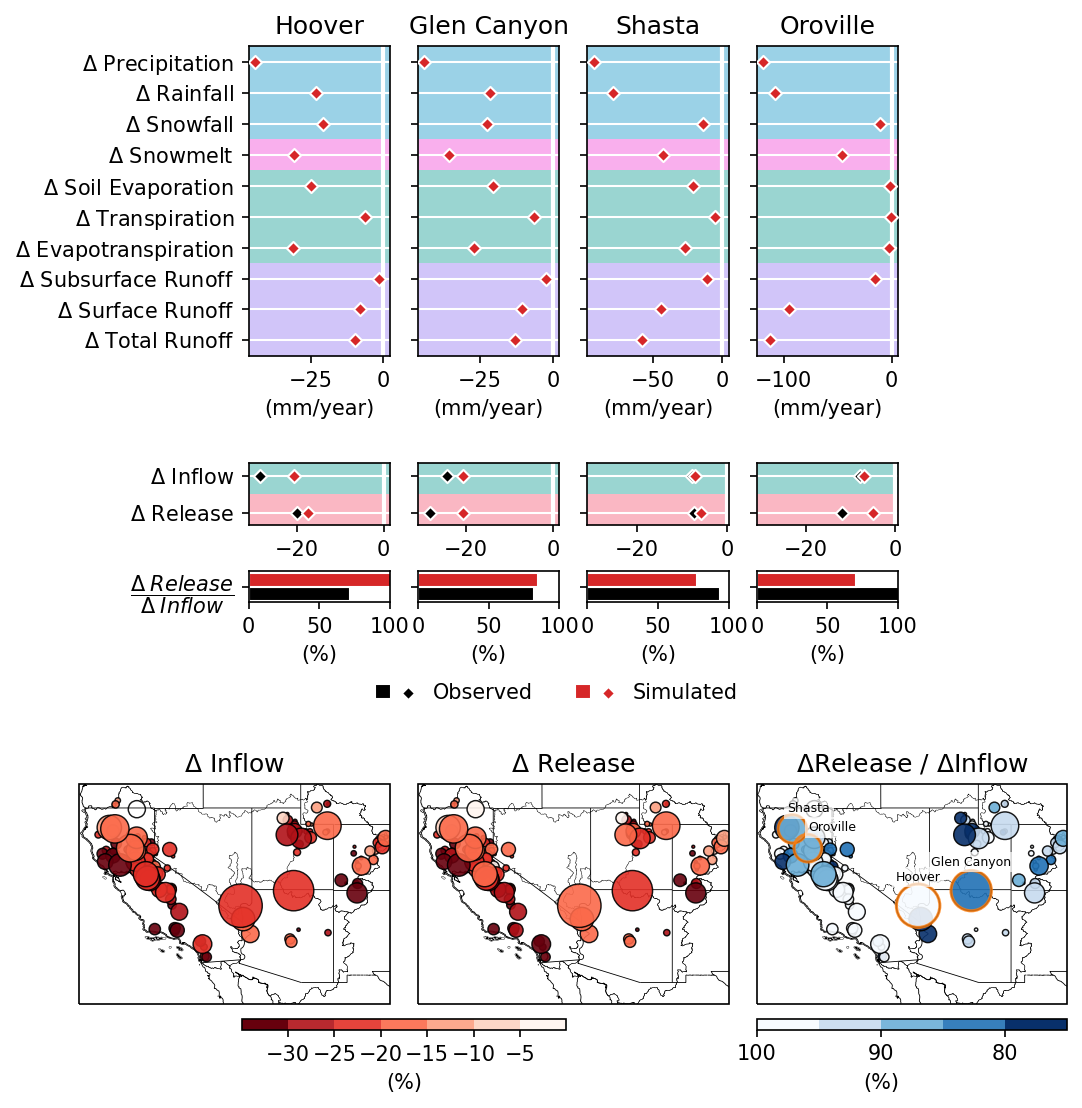

In [32]:
yvars = ['PREC', 'RAIN', 'SNOW',  'QSNOMELT', 'QSOIL', 'QVEGT', 'ET', 'QDRAI', 'QOVER', 'QRUNOFF']
ylabels = [r'$\Delta$ Precipitation', r'$\Delta$ Rainfall', r'$\Delta$ Snowfall', r'$\Delta$ Snowmelt',
           r'$\Delta$ Soil Evaporation', r'$\Delta$ Transpiration', r'$\Delta$ Evapotranspiration',
           r'$\Delta$ Subsurface Runoff', r'$\Delta$ Surface Runoff', r'$\Delta$ Total Runoff']
colors = [c_q,c_q,c_q,
          c_et,c_et,c_et,
          c_melt,
          c_prec,c_prec,c_prec]

yvars2 = ['delI', 'delR']
ylabels2  = [r'$\Delta$ Inflow', r'$\Delta$ Release']
colors2 = [palette[0],c_et,c_q]
xlims = [(-31,None),(-31,None),(-31,None),(-31,None),
 (-10.5,None),(-15,5),(-10.5,None),(None,None)
]

fig = plt.figure(figsize=(8.5,9), dpi=150)
gspec = gridspec.GridSpec(nrows=6, ncols=6, figure=fig, height_ratios=[1,.05,.2,.1, 0.2, 1],
                         hspace=.35)

damids_plot = ['610', '597','132', '148']
for i in range(len(damids_plot)):
    damid = damids_plot[i]
    if i < 4:
        ax0 = plt.subplot(gspec[0,i+1])
        ax1 = plt.subplot(gspec[2,i+1])
        ax2 = plt.subplot(gspec[3,i+1])
        
    ax = ax0
    for j,c in zip(range(0,len(ylabels)), colors):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data = df_del_res.loc[damid].loc[yvars].reset_index()[::-1]
    data.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(mm/year)')
    ax.set_yticks(range(len(ylabels))[::-1], ['']*len(ylabels))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels))[::-1], ylabels)
    ax.set_ylabel('')
    ax.set_title(daminfo.loc[int(damid)]['Project name'])
    ax.set_ylim(-0.5, len(ylabels)-.5)

    ax = ax1
    for j,c in zip(range(0,len(ylabels2)), colors2):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data_obs = df_del_res_ir.loc[damid, 'obs'].loc[yvars2].reset_index()[::-1]
    data_mdl = df_del_res_ir.loc[damid, 'mdl'].loc[yvars2].reset_index()[::-1]
    data_obs.plot.scatter(y='index', x=damid, marker='D', c='k', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9, label='Observed')
    data_mdl.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9, label='Simulated')
    ax.set_xlabel('')
    ax.set_yticks(range(len(ylabels2))[::-1], ['']*len(ylabels2))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels2))[::-1], ylabels2)
    ax.set_ylabel('')
    ax.set_ylim(-0.35,1.35)
    if xlims[i][0] is not None:
        ax.set_xlim(*xlims[i])
    # ax.margins(0.1)
    ax.get_legend().remove()
    p1 , p2 =  ax.get_legend_handles_labels()[0]

    ax = ax2
    val_obs = df_del_res_ir.loc[damid, 'obs'].loc['(dR/dI)']
    val_mdl = df_del_res_ir.loc[damid, 'mdl'].loc['(dR/dI)']
    ax.barh(0, val_obs, height=1, color='k', edgecolor='w', label='Observed')
    # ax.barh(0, 100-val_obs, left=val_obs, height=1, color='k', edgecolor='w', hatch=['xxxxx'])
    ax.barh(1, val_mdl, height=1, color='tab:red', edgecolor='w', label='Simulated')
    # ax.barh(1, 100-val_mdl, left=val_mdl, height=1, color='tab:red', edgecolor='w', hatch=['xxxxx'])
    ax.set_yticks([0.5], [''])
    if i==0 or i==4:
        ax.set_yticks([0.5], [r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$'])
    ax.set_xlim(0,100)
    ax.set_xlabel('(%)')
    p3 , p4 =  ax.get_legend_handles_labels()[0]
    # if i==3: break


ax.legend([(p3, p1), (p4,p2)], ['Observed', 'Simulated'], ncol=2,
               handler_map={tuple: HandlerTuple(ndivide=None)},
         bbox_to_anchor=(0,-2), frameon=False)

df = df_alldams.copy()
df['size'] = np.maximum(np.log10(daminfo_obs['Total storage (FSL, Mm3)']),0)**4
df = df.sort_values('size')
#
ax0 = plt.subplot(gspec[5,:2], projection=ccrs.PlateCarree())
ax1 = plt.subplot(gspec[5,2:4], projection=ccrs.PlateCarree())
axes = [ax0, ax1]
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
extent = (-124.6, -105.6, 30.02, 43.46)
metrics = ('dI', 'dR')
cmap = 'Reds_r'
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(-30,0,5), ncolors=256, extend='both')
titles = [r'$\Delta$ Inflow', r'$\Delta$ Release']
for ax,metric,title in zip(axes, metrics, titles):
    ax.set_title(title)
    gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
    ax.add_feature(cfeature.BORDERS, lw=.4)
    ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
    ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
    fc = ax.scatter(df['Lon'], df['Lat'], c=df[metric], s=df['size'], alpha=.9, 
                    cmap=cmap, norm=norm, edgecolor='k', lw=.7, zorder=2)
    ax.set_extent(extent)
cb = plt.colorbar(fc,ax=axes,label='(%)', location='bottom',aspect=30, shrink=.5,
                  extendfrac='auto', extendrect=True, pad=0.05)
#
cmap = 'Blues'
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,21,5), ncolors=256, extend='max')
ax = plt.subplot(gspec[5,4:], projection=ccrs.PlateCarree())
# ax.set_title(r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$')
ax.set_title(r'$\Delta$Release $/$ $\Delta$Inflow')
gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
ax.add_feature(cfeature.BORDERS, lw=.4)
ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
fc = ax.scatter(df['Lon'], df['Lat'], c=(100-df['(dR/dI)']), s=df['size'], alpha=.9, 
                cmap=cmap, norm=norm, edgecolor='k', lw=.7, zorder=2)
ax.set_extent(extent)
cb = plt.colorbar(fc,ax=ax, label='(%)', location='bottom',aspect=30,
                  extendfrac='auto', extendrect=True, pad=0.05)
# cb.ax.set_xticks([0,10,20,30,40], [100,90,80,70,60]);
cb.ax.set_xticks([0,10,20], [100,90,80]);

sel_damids = [610,597,132,148]
offsets = [1.8,1.8,.75,.75]
ax.scatter(df.loc[sel_damids]['Lon'], df.loc[sel_damids]['Lat'], 
           c='None', s=df.loc[sel_damids]['size'], alpha=.8, edgecolor='tab:orange', ls='-', lw=1.5, zorder=4)

offset = [(0,1.75),(0,1.75), (1,1.25), (1.5,1.25)]
for i, damid in enumerate(sel_damids[:4]):
    xf,yf = offset[i]
    ax.annotate(df.loc[damid, 'Project name'], color='k', fontsize=6,
            xy=(df.loc[damid, 'Lon']+xf, df.loc[damid, 'Lat']+yf), xycoords='data',
            # xytext=(df.loc[damid, 'Lon'], df.loc[damid, 'Lat']), textcoords='data',
            ha="center", va="center",
            bbox=dict(boxstyle="square", fc="w", edgecolor="None", alpha=.7), zorder=9)

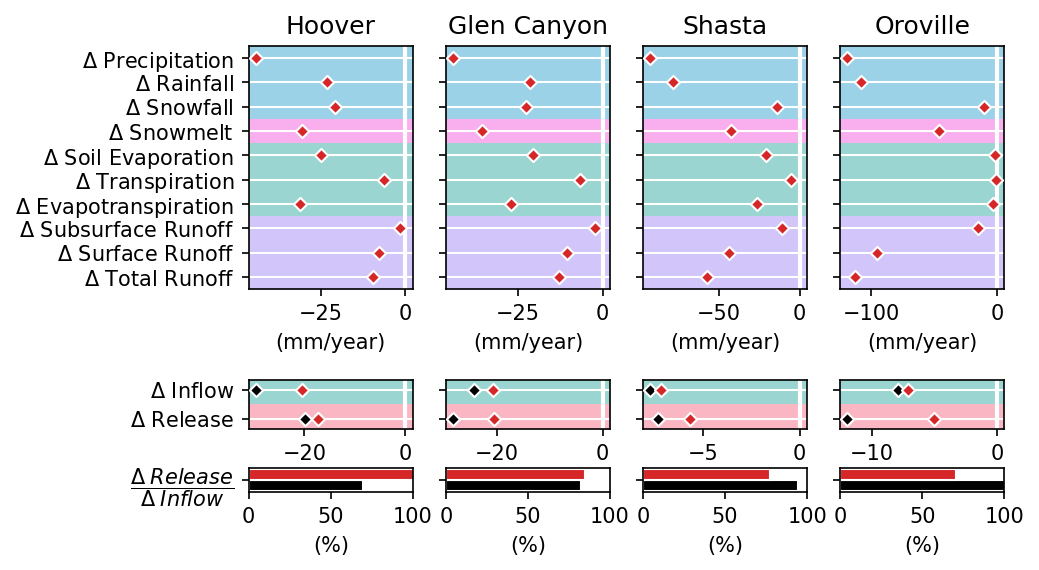

In [71]:
yvars = ['PREC', 'RAIN', 'SNOW',  'QSNOMELT', 'QSOIL', 'QVEGT', 'ET', 'QDRAI', 'QOVER', 'QRUNOFF']
ylabels = [r'$\Delta$ Precipitation', r'$\Delta$ Rainfall', r'$\Delta$ Snowfall', r'$\Delta$ Snowmelt',
           r'$\Delta$ Soil Evaporation', r'$\Delta$ Transpiration', r'$\Delta$ Evapotranspiration',
           r'$\Delta$ Subsurface Runoff', r'$\Delta$ Surface Runoff', r'$\Delta$ Total Runoff']
colors = [c_q,c_q,c_q,
          c_et,c_et,c_et,
          c_melt,
          c_prec,c_prec,c_prec]

yvars2 = ['delI', 'delR']
ylabels2  = [r'$\Delta$ Inflow', r'$\Delta$ Release']
colors2 = [palette[0],c_et,c_q]
xlims = [(None,None),(None,None),(None,None),(None,None),
 (-10.5,None),(-15,5),(-10.5,None),(None,None)
]

fig = plt.figure(figsize=(6.5,9), dpi=150)
gspec = gridspec.GridSpec(nrows=9, ncols=4, figure=fig, height_ratios=[1,.05,.2,.1, 0.2, 1,0.05,.2,.1],
                         hspace=.5)

damids_plot = ['610', '597','132', '148']
for i in range(len(damids_plot)):
    damid = damids_plot[i]
    if i < 4:
        ax0 = plt.subplot(gspec[0,i])
        ax1 = plt.subplot(gspec[2,i])
        ax2 = plt.subplot(gspec[3,i])
        
    else:
        ax0 = plt.subplot(gspec[5,i-4])
        ax1 = plt.subplot(gspec[7,i-4])
        ax2 = plt.subplot(gspec[8,i-4])

    ax = ax0
    for j,c in zip(range(0,len(ylabels)), colors):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data = df_del_res.loc[damid].loc[yvars].reset_index()[::-1]
    data.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(mm/year)')
    ax.set_yticks(range(len(ylabels))[::-1], ['']*len(ylabels))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels))[::-1], ylabels)
    ax.set_ylabel('')
    ax.set_title(daminfo.loc[int(damid)]['Project name'])
    ax.set_ylim(-0.5, len(ylabels)-.5)

    ax = ax1
    for j,c in zip(range(0,len(ylabels2)), colors2):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data_obs = df_del_res_ir.loc[damid, 'obs'].loc[yvars2].reset_index()[::-1]
    data_mdl = df_del_res_ir.loc[damid, 'mdl'].loc[yvars2].reset_index()[::-1]
    data_obs.plot.scatter(y='index', x=damid, marker='D', c='k', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    data_mdl.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(%)')
    ax.set_yticks(range(len(ylabels2))[::-1], ['']*len(ylabels2))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels2))[::-1], ylabels2)
    ax.set_ylabel('')
    ax.set_ylim(-0.35,1.35)
    if xlims[i][0] is not None:
        ax.set_xlim(*xlims[i])
    # ax.margins(0.1)

    ax = ax2
    val_obs = df_del_res_ir.loc[damid, 'obs'].loc['(dR/dI)']
    val_mdl = df_del_res_ir.loc[damid, 'mdl'].loc['(dR/dI)']
    ax.barh(0, val_obs, height=1, color='k', edgecolor='w',)
    # ax.barh(0, 100-val_obs, left=val_obs, height=1, color='k', edgecolor='w', hatch=['xxxxx'])
    ax.barh(1, val_mdl, height=1, color='tab:red', edgecolor='w',)
    # ax.barh(1, 100-val_mdl, left=val_mdl, height=1, color='tab:red', edgecolor='w', hatch=['xxxxx'])
    ax.set_yticks([0.5], [''])
    if i==0 or i==4:
        ax.set_yticks([0.5], [r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$'])
    ax.set_xlim(0,100)
    ax.set_xlabel('(%)')
    # if i==3: break

# ax = plt.subplot(gspec[3,0])
# ax = plt.subplot(gspec[4,0])

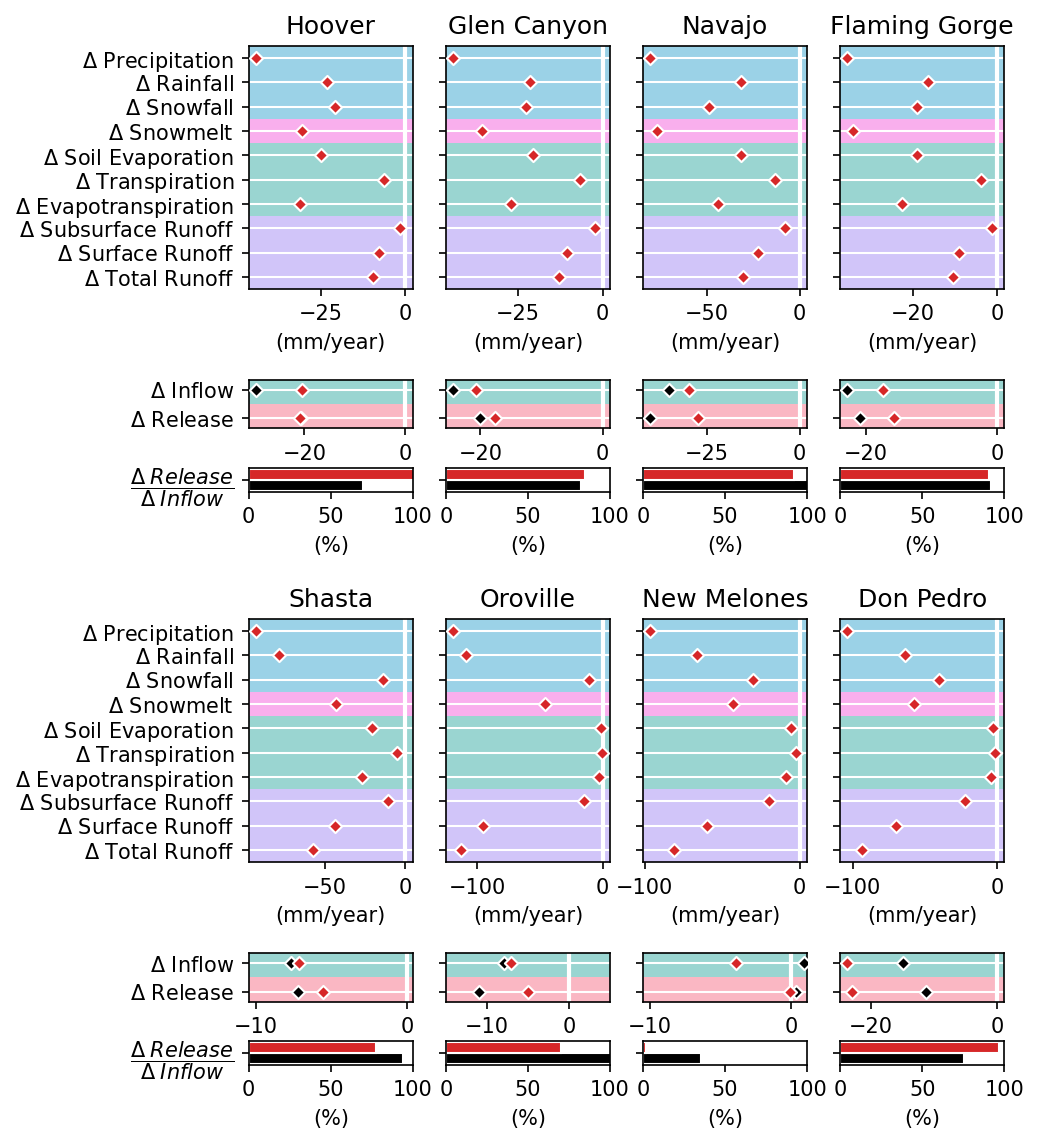

In [23]:
yvars = ['PREC', 'RAIN', 'SNOW',  'QSNOMELT', 'QSOIL', 'QVEGT', 'ET', 'QDRAI', 'QOVER', 'QRUNOFF']
ylabels = [r'$\Delta$ Precipitation', r'$\Delta$ Rainfall', r'$\Delta$ Snowfall', r'$\Delta$ Snowmelt',
           r'$\Delta$ Soil Evaporation', r'$\Delta$ Transpiration', r'$\Delta$ Evapotranspiration',
           r'$\Delta$ Subsurface Runoff', r'$\Delta$ Surface Runoff', r'$\Delta$ Total Runoff']
colors = [c_q,c_q,c_q,
          c_et,c_et,c_et,
          c_melt,
          c_prec,c_prec,c_prec]

yvars2 = ['delI', 'delR']
ylabels2  = [r'$\Delta$ Inflow', r'$\Delta$ Release']
colors2 = [palette[0],c_et,c_q]
xlims = [(None,None),(None,None),(None,None),(None,None),
 (-10.5,None),(-15,5),(-10.5,None),(None,None)
]

fig = plt.figure(figsize=(6.5,9), dpi=150)
gspec = gridspec.GridSpec(nrows=9, ncols=4, figure=fig, height_ratios=[1,.05,.2,.1, 0.2, 1,0.05,.2,.1],
                         hspace=.5)

for i in range(len(damids)):
    damid = damids[i]
    if i < 4:
        ax0 = plt.subplot(gspec[0,i])
        ax1 = plt.subplot(gspec[2,i])
        ax2 = plt.subplot(gspec[3,i])
        
    else:
        ax0 = plt.subplot(gspec[5,i-4])
        ax1 = plt.subplot(gspec[7,i-4])
        ax2 = plt.subplot(gspec[8,i-4])

    ax = ax0
    for j,c in zip(range(0,len(ylabels)), colors):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data = df_del_res.loc[damid].loc[yvars].reset_index()[::-1]
    data.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(mm/year)')
    ax.set_yticks(range(len(ylabels))[::-1], ['']*len(ylabels))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels))[::-1], ylabels)
    ax.set_ylabel('')
    ax.set_title(daminfo.loc[int(damid)]['Project name'])
    ax.set_ylim(-0.5, len(ylabels)-.5)

    ax = ax1
    for j,c in zip(range(0,len(ylabels2)), colors2):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data_obs = df_del_res_ir.loc[damid, 'obs'].loc[yvars2].reset_index()[::-1]
    data_mdl = df_del_res_ir.loc[damid, 'mdl'].loc[yvars2].reset_index()[::-1]
    data_obs.plot.scatter(y='index', x=damid, marker='D', c='k', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    data_mdl.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(%)')
    ax.set_yticks(range(len(ylabels2))[::-1], ['']*len(ylabels2))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels2))[::-1], ylabels2)
    ax.set_ylabel('')
    ax.set_ylim(-0.35,1.35)
    if xlims[i][0] is not None:
        ax.set_xlim(*xlims[i])
    # ax.margins(0.1)

    ax = ax2
    val_obs = df_del_res_ir.loc[damid, 'obs'].loc['(dR/dI)']
    val_mdl = df_del_res_ir.loc[damid, 'mdl'].loc['(dR/dI)']
    ax.barh(0, val_obs, height=1, color='k', edgecolor='w',)
    # ax.barh(0, 100-val_obs, left=val_obs, height=1, color='k', edgecolor='w', hatch=['xxxxx'])
    ax.barh(1, val_mdl, height=1, color='tab:red', edgecolor='w',)
    # ax.barh(1, 100-val_mdl, left=val_mdl, height=1, color='tab:red', edgecolor='w', hatch=['xxxxx'])
    ax.set_yticks([0.5], [''])
    if i==0 or i==4:
        ax.set_yticks([0.5], [r'$\dfrac{\Delta \;Release}{\Delta \;Inflow}$'])
    ax.set_xlim(0,100)
    ax.set_xlabel('(%)')
    # if i==3: break

# ax = plt.subplot(gspec[3,0])
# ax = plt.subplot(gspec[4,0])

In [ ]:
yvars = ['PREC', 'RAIN', 'SNOW',  'QSNOMELT', 'QSOIL', 'QVEGT', 'ET', 'QDRAI', 'QOVER', 'QRUNOFF']
ylabels = [r'$\Delta$ Precipitation', r'$\Delta$ Rainfall', r'$\Delta$ Snowfall', r'$\Delta$ Snowmelt',
           r'$\Delta$ Soil Evaporation', r'$\Delta$ Transpiration', r'$\Delta$ Evapotranspiration',
           r'$\Delta$ Subsurface Runoff', r'$\Delta$ Surface Runoff', r'$\Delta$ Total Runoff']
colors = [c_q,c_q,c_q,
          c_et,c_et,c_et,
          c_melt,
          c_prec,c_prec,c_prec]

yvars2 = ['delI', 'delR', 'del(I-R)']
ylabels2  = [r'$\Delta$ Inflow', r'$\Delta$ Release', r'$\Delta$ (Inflow - Release)']
colors2 = [palette[0],c_et,c_q]

xlims = [(None,None),(None,None),(None,None),(None,None),
 (-10.5,None),(-15,5),(-3,None),(None,None)
]

fig = plt.figure(figsize=(6.5,9), dpi=150)
gspec = gridspec.GridSpec(nrows=5, ncols=4, figure=fig, height_ratios=[1,.35,0.1,1,.35],
                         hspace=.5)

for i in range(len(damids)):
    damid = damids[i]
    if i < 4:
        ax0 = plt.subplot(gspec[0,i])
        ax1 = plt.subplot(gspec[1,i])
    else:
        ax0 = plt.subplot(gspec[3,i-4])
        ax1 = plt.subplot(gspec[4,i-4])
    
    ax = ax0
    for j,c in zip(range(0,len(ylabels)), colors):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data = df_del_res.loc[damid].loc[yvars].reset_index()[::-1]
    data.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(mm/year)')
    ax.set_yticks(range(len(ylabels))[::-1], ['']*len(ylabels))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels))[::-1], ylabels)
    ax.set_ylabel('')
    ax.set_title(daminfo.loc[int(damid)]['Project name'])
    ax.set_ylim(-0.5, len(ylabels)-.5)

    ax = ax1
    for j,c in zip(range(0,len(ylabels2)), colors2):
        ax.axhspan(j-0.5, j+0.5, facecolor=c, alpha=0.5)
        ax.axhline(j, lw=1, c='w')
    ax.axvline(0, c='w',lw=2)
    data_obs = df_del_res_ir.loc[damid, 'obs'].loc[yvars2].reset_index()[::-1]
    data_mdl = df_del_res_ir.loc[damid, 'mdl'].loc[yvars2].reset_index()[::-1]
    data_obs.plot.scatter(y='index', x=damid, marker='D', c='k', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    data_mdl.plot.scatter(y='index', x=damid, marker='D', c='tab:red', edgecolor='w', 
                      linewidth=1., ax=ax, zorder=9)
    ax.set_xlabel('(%)')
    ax.set_yticks(range(len(ylabels2))[::-1], ['']*len(ylabels2))
    if i==0 or i==4:
        ax.set_yticks(range(len(ylabels2))[::-1], ylabels2)
    ax.set_ylabel('')
    ax.set_ylim(-0.35,2.35)
    if xlims[i][0] is not None:
        ax.set_xlim(*xlims[i])
    # ax.margins(0.1)
    # if i==3: break

# ax = plt.subplot(gspec[3,0])
# ax = plt.subplot(gspec[4,0])